In [1]:
# for local
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
# ====================================================
# Directory settings
# ====================================================
import os

EXP_NAME='1102_C_classificatoin_lstm_hidden=1024_ver11_mod-feat11'

DATA_DIR = "../input/ventilator-pressure-prediction/"

OUTPUT_DIR = f'./results/{EXP_NAME}/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Config

In [3]:
# ====================================================
# CFG
# ====================================================
class CFG:
    experiment_name=EXP_NAME
    competition='ventilator'
    apex=True
    print_freq=1000
    num_workers=4
    model_name='lstm'
    scheduler='CosineAnnealingWarmRestarts' # ['linear', 'cosine', 'ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    batch_scheduler=False
    #num_warmup_steps=100 # ['linear', 'cosine']
    #num_cycles=0.5 # 'cosine'
    factor=0.995 # ReduceLROnPlateau
    patience=7 # ReduceLROnPlateau
    eps=1e-6 # ReduceLROnPlateau
    T_max=50 # CosineAnnealingLR
    T_0=20 # CosineAnnealingWarmRestarts
    epochs=25
    max_grad_norm=1000
    gradient_accumulation_steps=1
    hidden_size=1024
    lr=1e-3
    min_lr=1e-5
    weight_decay=1e-6
    batch_size=512
    n_fold=5
    trn_fold=[0, 1, 2, 3, 4]
    cate_seq_cols=[]
    cont_seq_cols=['R', 'time_step', 'u_in', 'u_out']
    train=True
    inference=True
    feature_importance=False
    debug=False
    wandb=True

if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold=[0]

# import

In [4]:
# ====================================================
# Library
# ====================================================
import os
import gc
import sys
import json
import math
import random
from time import time
from datetime import datetime
from collections import Counter, defaultdict

import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from tqdm.auto import tqdm
import category_encoders as ce

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from torch.cuda.amp import GradScaler
from torch.cuda.amp import autocast

from transformers import AdamW
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup

import warnings
warnings.filterwarnings("ignore")

#if CFG.apex:
#    from apex import amp

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Utils

In [5]:
# ====================================================
# Utils
# ====================================================
# def get_score(y_trues, y_preds):
#     score = mean_absolute_error(y_trues, y_preds)
#     return score


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything()

def decorate(s: str, decoration=None):
    if decoration is None:
        decoration = '★' * 20

    return ' '.join([decoration, str(s), decoration])

class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' ', verbose=0):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None
        self.verbose = verbose

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        if self.verbose is None:
            return
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

# data loading

In [6]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv(DATA_DIR + 'train.csv')
if CFG.debug:
    train = train[:80*5000]
test = pd.read_csv(DATA_DIR + 'test.csv')
sub = pd.read_csv(DATA_DIR + 'sample_submission.csv')

display(train.head())
display(test.head())
display(sub.head())

unique_pressures = train["pressure"].unique()
sorted_pressures = np.sort(unique_pressures)
total_pressures_len = len(sorted_pressures)

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


,id,breath_id,R,C,time_step,u_in,u_out
0,1,0,5,20,0.000000,0.000000,0
1,2,0,5,20,0.031904,7.515046,0
2,3,0,5,20,0.063827,14.651675,0
3,4,0,5,20,0.095751,21.230610,0
4,5,0,5,20,0.127644,26.320956,0


,id,pressure
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


# create features

In [7]:
class AbstractBaseBlock:
    def fit(self, input_df: pd.DataFrame, y=None):
        return self.transform(input_df)

    def transform(self, input_df: pd.DataFrame) -> pd.DataFrame:
        raise NotImplementedError()


class AddMultiplyingDividing(AbstractBaseBlock):
    def transform(self, input_df):
        input_df['area'] = input_df['time_step'] * input_df['u_in']
        input_df['area'] = input_df.groupby('breath_id')['area'].cumsum()
        input_df['cross'] = input_df['u_in']*input_df['u_out']
        input_df['cross2'] = input_df['time_step']*input_df['u_out']
        input_df['u_in_cumsum'] = (input_df['u_in']).groupby(input_df['breath_id']).cumsum()
        input_df['one'] = 1
        input_df['count'] = (input_df['one']).groupby(input_df['breath_id']).cumsum()
        input_df['u_in_cummean'] = input_df['u_in_cumsum'] / input_df['count']
        # input_df = input_df.merge(
        #     input_df[input_df["u_out"]==0].groupby('breath_id')['u_in'].agg(["mean", "std", "max"]).add_prefix("u_out0_").reset_index(),
        #     on="breath_id"
        # )
        # input_df = input_df.merge(
        #     input_df[input_df["u_out"]==1].groupby('breath_id')['u_in'].agg(["mean", "std", "max"]).add_prefix("u_out1_").reset_index(),
        #     on="breath_id"
        # )

        # feat-11
        input_df['time_step_cumsum'] = input_df.groupby(['breath_id'])['time_step'].cumsum()
        input_df['breath_id__u_in__max'] = input_df.groupby(['breath_id'])['u_in'].transform('max')
        input_df['breath_id__u_in__mean'] = input_df.groupby(['breath_id'])['u_in'].transform('mean')
        input_df['breath_id__u_in__diffmax'] = input_df.groupby(['breath_id'])['u_in'].transform('max') - input_df['u_in']
        input_df['breath_id__u_in__diffmean'] = input_df.groupby(['breath_id'])['u_in'].transform('mean') - input_df['u_in']

        output_df = pd.DataFrame(
            {
                "area": input_df['area'],
                #"cross": input_df['cross'],
                #"cross2": input_df['cross2'],
                "u_in_cumsum": input_df['u_in_cumsum'],
                "u_in_cummean": input_df['u_in_cummean'],
                'time_step_cumsum': input_df['time_step_cumsum'],
                "breath_id__u_in__max": input_df['breath_id__u_in__max'],
                "breath_id__u_in__mean": input_df['breath_id__u_in__mean'],
                "breath_id__u_in__diffmax": input_df['breath_id__u_in__diffmax'],
                "breath_id__u_in__diffmean": input_df['breath_id__u_in__diffmean'],
                'count': input_df['count'],

            }
        )
        CFG.cont_seq_cols += output_df.add_suffix(f'@{self.__class__.__name__}').columns.tolist()
        return output_df


class RCDummry(AbstractBaseBlock):
    def transform(self, input_df):
        input_df['R_dummy'] = input_df['R'].astype(str)
        #input_df['C_dummy'] = input_df['C'].astype(str)
        #input_df['RC_dummy'] = input_df['R_dummy'] + input_df['C_dummy']
        output_df = pd.get_dummies(input_df[["R_dummy"]])
        CFG.cont_seq_cols += output_df.add_suffix(f'@{self.__class__.__name__}').columns.tolist()
        return output_df


class AddBreathTimeAndUInTime(AbstractBaseBlock):
    def transform(self, input_df):
        output_df = pd.DataFrame(
            {
                "breath_time": input_df['time_step'] - input_df['time_step'].shift(1),
                "u_in_time": input_df['u_in'] - input_df['u_in'].shift(1)
            }
        )
        output_df.loc[input_df['time_step'] == 0, 'breath_time'] = output_df['breath_time'].mean()
        output_df.loc[input_df['time_step'] == 0, 'u_in_time'] = output_df['u_in_time'].mean()
        CFG.cont_seq_cols += output_df.add_suffix(f'@{self.__class__.__name__}').columns.tolist()
        return output_df

class LagFeatures(AbstractBaseBlock):
    def transform(self, input_df):
        output_df = pd.DataFrame(
            {
                "u_in_lag1": input_df.groupby("breath_id")["u_in"].shift(1).fillna(0),
                "u_in_lag2": input_df.groupby("breath_id")["u_in"].shift(2).fillna(0),
                "u_in_lag3": input_df.groupby("breath_id")["u_in"].shift(3).fillna(0),
                "u_in_lag4": input_df.groupby("breath_id")["u_in"].shift(4).fillna(0),
                "u_in_lag-1": input_df.groupby("breath_id")["u_in"].shift(-1).fillna(0),
                "u_in_lag-2": input_df.groupby("breath_id")["u_in"].shift(-2).fillna(0),
                "u_in_lag-3": input_df.groupby("breath_id")["u_in"].shift(-3).fillna(0),
                "u_in_lag-4": input_df.groupby("breath_id")["u_in"].shift(-4).fillna(0),
                "u_out_lag1": input_df.groupby("breath_id")["u_out"].shift(1).fillna(0),
                "u_out_lag2": input_df.groupby("breath_id")["u_out"].shift(2).fillna(0),
                "u_out_lag3": input_df.groupby("breath_id")["u_out"].shift(3).fillna(0),
                "u_out_lag4": input_df.groupby("breath_id")["u_out"].shift(4).fillna(0),
                "u_out_lag-1": input_df.groupby("breath_id")["u_out"].shift(-1).fillna(0),
                "u_out_lag-2": input_df.groupby("breath_id")["u_out"].shift(-2).fillna(0),
                "u_out_lag-3": input_df.groupby("breath_id")["u_out"].shift(-3).fillna(0),
                "u_out_lag-4": input_df.groupby("breath_id")["u_out"].shift(-4).fillna(0),
            }
        )
        output_df["u_in_lag1_diff"] = input_df["u_in"] - output_df["u_in_lag1"]
        output_df["u_in_lag2_diff"] = input_df["u_in"] - output_df["u_in_lag2"]
        output_df["u_in_lag3_diff"] = input_df["u_in"] - output_df["u_in_lag3"]
        output_df["u_in_lag4_diff"] = input_df["u_in"] - output_df["u_in_lag4"]
        output_df["u_out_lag1_diff"] = input_df["u_out"] - output_df["u_out_lag1"]
        output_df["u_out_lag2_diff"] = input_df["u_out"] - output_df["u_out_lag2"]
        output_df["u_out_lag3_diff"] = input_df["u_out"] - output_df["u_out_lag3"]
        output_df["u_out_lag4_diff"] = input_df["u_out"] - output_df["u_out_lag4"]
        output_df["u_in_lag-1_diff"] = input_df["u_in"] - output_df["u_in_lag-1"]
        output_df["u_in_lag-2_diff"] = input_df["u_in"] - output_df["u_in_lag-2"]
        output_df["u_out_lag-1_diff"] = input_df["u_out"] - output_df["u_out_lag-1"]
        output_df["u_out_lag-2_diff"] = input_df["u_out"] - output_df["u_out_lag-2"]

        output_df['u_in_ewm9'] = (input_df.groupby('breath_id')['u_in'].ewm(halflife=9).mean().reset_index(level=0,drop=True))
        output_df['u_in_ewm15'] = (input_df.groupby('breath_id')['u_in'].ewm(halflife=15).mean().reset_index(level=0,drop=True))

        # output_df["u_in_rolling_mean2"] = input_df[["breath_id", "u_in"]].groupby("breath_id").rolling(2).mean()["u_in"].reset_index(drop=True)
        output_df["u_in_rolling_mean4"] = input_df[["breath_id", "u_in"]].groupby("breath_id").rolling(4).mean()["u_in"].reset_index(drop=True)
        output_df["u_in_rolling_mean15"] = input_df[["breath_id", "u_in"]].groupby("breath_id").rolling(15).mean()["u_in"].reset_index(drop=True)
        if not CFG.debug:
            # output_df["u_in_rolling_max2"] = input_df[["breath_id", "u_in"]].groupby("breath_id").rolling(2).max()["u_in"].reset_index(drop=True)
            output_df["u_in_rolling_max4"] = input_df[["breath_id", "u_in"]].groupby("breath_id").rolling(4).max()["u_in"].reset_index(drop=True)
            output_df["u_in_rolling_max15"] = input_df[["breath_id", "u_in"]].groupby("breath_id").rolling(15).max()["u_in"].reset_index(drop=True)
            # output_df["u_in_rolling_min2"] = input_df[["breath_id", "u_in"]].groupby("breath_id").rolling(2).min()["u_in"].reset_index(drop=True)
            output_df["u_in_rolling_min4"] = input_df[["breath_id", "u_in"]].groupby("breath_id").rolling(4).min()["u_in"].reset_index(drop=True)
            output_df["u_in_rolling_min15"] = input_df[["breath_id", "u_in"]].groupby("breath_id").rolling(15).min()["u_in"].reset_index(drop=True)
            # output_df["u_in_rolling_std2"] = input_df[["breath_id", "u_in"]].groupby("breath_id").rolling(2).std()["u_in"].reset_index(drop=True)
            output_df["u_in_rolling_std4"] = input_df[["breath_id", "u_in"]].groupby("breath_id").rolling(4).std()["u_in"].reset_index(drop=True)
            output_df["u_in_rolling_std15"] = input_df[["breath_id", "u_in"]].groupby("breath_id").rolling(15).std()["u_in"].reset_index(drop=True)
            # output_df["u_in_rolling_sum2"] = input_df[["breath_id", "u_in"]].groupby("breath_id").rolling(2).sum()["u_in"].reset_index(drop=True)
            output_df["u_in_rolling_sum4"] = input_df[["breath_id", "u_in"]].groupby("breath_id").rolling(4).sum()["u_in"].reset_index(drop=True)
            output_df["u_in_rolling_sum15"] = input_df[["breath_id", "u_in"]].groupby("breath_id").rolling(15).sum()["u_in"].reset_index(drop=True)
        for col in output_df.columns:
            output_df[col] = output_df[col].fillna(output_df[col].mean())
        CFG.cont_seq_cols += output_df.add_suffix(f'@{self.__class__.__name__}').columns.tolist()
        return output_df

In [8]:
feature_blocks = [
    AddMultiplyingDividing(),
    AddBreathTimeAndUInTime(),
    RCDummry(),
    LagFeatures()
]

In [9]:
def run_blocks(input_df, blocks, y=None, test=False):
    out_df = pd.DataFrame()

    print(decorate('start run blocks...'))

    with Timer(prefix='run test={}'.format(test)):
        for block in feature_blocks:
            with Timer(prefix='out_df shape: {} \t- {}'.format(out_df.shape, str(block))):
                if not test:
                    out_i = block.fit(input_df.copy(), y=y)
                else:
                    out_i = block.transform(input_df.copy())

            assert len(input_df) == len(out_i), block
            name = block.__class__.__name__
            out_df = pd.concat([out_df, out_i.add_suffix(f'@{name}')], axis=1)
    print(f"out_df shape: {out_df.shape}")

    return pd.concat([input_df, out_df], axis=1)

train = run_blocks(train, blocks=feature_blocks)
test = run_blocks(test, blocks=feature_blocks, test=True)

CFG.cont_seq_cols = list(set(CFG.cont_seq_cols))
display(train.head())
display(test.head())

★★★★★★★★★★★★★★★★★★★★ start run blocks... ★★★★★★★★★★★★★★★★★★★★
out_df shape: (0, 0) 	- <__main__.AddMultiplyingDividing object at 0x7f853e4ccd50> 1.143[s]
out_df shape: (6036000, 9) 	- <__main__.AddBreathTimeAndUInTime object at 0x7f853e4cc810> 0.148[s]
out_df shape: (6036000, 11) 	- <__main__.RCDummry object at 0x7f853e4ccbd0> 5.667[s]
out_df shape: (6036000, 14) 	- <__main__.LagFeatures object at 0x7f853e4ccf50> 60.072[s]
run test=False 68.508[s]
out_df shape: (6036000, 54)
★★★★★★★★★★★★★★★★★★★★ start run blocks... ★★★★★★★★★★★★★★★★★★★★
out_df shape: (0, 0) 	- <__main__.AddMultiplyingDividing object at 0x7f853e4ccd50> 0.658[s]
out_df shape: (4024000, 9) 	- <__main__.AddBreathTimeAndUInTime object at 0x7f853e4cc810> 0.052[s]
out_df shape: (4024000, 11) 	- <__main__.RCDummry object at 0x7f853e4ccbd0> 3.802[s]
out_df shape: (4024000, 14) 	- <__main__.LagFeatures object at 0x7f853e4ccf50> 39.991[s]
run test=True 45.418[s]
out_df shape: (4024000, 54)


,id,breath_id,R,C,time_step,u_in,u_out,pressure,area@AddMultiplyingDividing,u_in_cumsum@AddMultiplyingDividing,u_in_cummean@AddMultiplyingDividing,time_step_cumsum@AddMultiplyingDividing,breath_id__u_in__max@AddMultiplyingDividing,breath_id__u_in__mean@AddMultiplyingDividing,breath_id__u_in__diffmax@AddMultiplyingDividing,breath_id__u_in__diffmean@AddMultiplyingDividing,count@AddMultiplyingDividing,breath_time@AddBreathTimeAndUInTime,u_in_time@AddBreathTimeAndUInTime,R_dummy_20@RCDummry,R_dummy_5@RCDummry,R_dummy_50@RCDummry,u_in_lag1@LagFeatures,u_in_lag2@LagFeatures,u_in_lag3@LagFeatures,u_in_lag4@LagFeatures,u_in_lag-1@LagFeatures,u_in_lag-2@LagFeatures,u_in_lag-3@LagFeatures,u_in_lag-4@LagFeatures,u_out_lag1@LagFeatures,u_out_lag2@LagFeatures,u_out_lag3@LagFeatures,u_out_lag4@LagFeatures,u_out_lag-1@LagFeatures,u_out_lag-2@LagFeatures,u_out_lag-3@LagFeatures,u_out_lag-4@LagFeatures,u_in_lag1_diff@LagFeatures,u_in_lag2_diff@LagFeatures,u_in_lag3_diff@LagFeatures,u_in_lag4_diff@LagFeatures,u_out_lag1_diff@LagFeatures,u_out_lag2_diff@LagFeatures,u_out_lag3_diff@LagFeatures,u_out_lag4_diff@LagFeatures,u_in_lag-1_diff@LagFeatures,u_in_lag-2_diff@LagFeatures,u_out_lag-1_diff@LagFeatures,u_out_lag-2_diff@LagFeatures,u_in_ewm9@LagFeatures,u_in_ewm15@LagFeatures,u_in_rolling_mean4@LagFeatures,u_in_rolling_mean15@LagFeatures,u_in_rolling_max4@LagFeatures,u_in_rolling_max15@LagFeatures,u_in_rolling_min4@LagFeatures,u_in_rolling_min15@LagFeatures,u_in_rolling_std4@LagFeatures,u_in_rolling_std15@LagFeatures,u_in_rolling_sum4@LagFeatures,u_in_rolling_sum15@LagFeatures
0,1,1,20,50,0.000000,0.083334,0,5.837492,0.000000,0.083334,0.083334,0.000000,28.313036,10.146007,28.229702,10.062673,1,4.370474e-07,2.318432e-07,1,0,0,0.000000,0.000000,0.000000,0.000000,18.383041,22.509278,22.808822,25.355850,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083334,0.083334,0.083334,0.083334,0.0,0.0,0.0,0.0,-18.299707,-22.425944,0.0,0.0,0.083334,0.083334,7.122734,6.293573,9.024859,11.255598,5.530754,2.927842,1.644297,2.874732,28.490936,94.403589
1,2,1,20,50,0.033652,18.383041,0,5.907794,0.618632,18.466375,9.233188,0.033652,28.313036,10.146007,9.929994,-8.237035,2,3.365231e-02,1.829971e+01,1,0,0,0.083334,0.000000,0.000000,0.000000,22.509278,22.808822,25.355850,27.259866,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.299707,18.383041,18.383041,18.383041,0.0,0.0,0.0,0.0,-4.126236,-4.425781,0.0,0.0,9.585358,9.444557,7.122734,6.293573,9.024859,11.255598,5.530754,2.927842,1.644297,2.874732,28.490936,94.403589
2,3,1,20,50,0.067514,22.509278,0,7.876254,2.138333,40.975653,13.658551,0.101167,28.313036,10.146007,5.803758,-12.363271,3,3.386211e-02,4.126236e+00,1,0,0,18.383041,0.083334,0.000000,0.000000,22.808822,25.355850,27.259866,27.127486,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.126236,22.425944,22.509278,22.509278,0.0,0.0,0.0,0.0,-0.299544,-2.846573,0.0,0.0,14.229040,14.002181,7.122734,6.293573,9.024859,11.255598,5.530754,2.927842,1.644297,2.874732,28.490936,94.403589
3,4,1,20,50,0.101542,22.808822,0,11.742872,4.454391,63.784476,15.946119,0.202709,28.313036,10.146007,5.504214,-12.662816,4,3.402781e-02,2.995445e-01,1,0,0,22.509278,18.383041,0.083334,0.000000,25.355850,27.259866,27.127486,26.807732,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.299544,4.425781,22.725488,22.808822,0.0,0.0,0.0,0.0,-2.547028,-4.451044,0.0,0.0,16.627759,16.358716,15.946119,6.293573,22.808822,11.255598,0.083334,2.927842,10.766279,2.874732,63.784476,94.403589
4,5,1,20,50,0.135756,25.355850,0,12.234987,7.896588,89.140326,17.828065,0.338464,28.313036,10.146007,2.957185,-15.209844,5,3.421330e-02,2.547028e+00,1,0,0,22.808822,22.509278,18.383041,0.083334,27.259866,27.127486,26.807732,27.864715,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.547028,2.846573,6.972809,25.272516,0.0,0.0,0.0,0.0,-1.904016,-1.771635,0.0,0.0,18.652046,18.328164,22.264248,6.293573,25.355850,11.255598,18.383041,2.927842,2.885502,2.874732,89.056992,94.403589


,id,breath_id,R,C,time_step,u_in,u_out,area@AddMultiplyingDividing,u_in_cumsum@AddMultiplyingDividing,u_in_cummean@AddMultiplyingDividing,time_step_cumsum@AddMultiplyingDividing,breath_id__u_in__max@AddMultiplyingDividing,breath_id__u_in__mean@AddMultiplyingDividing,breath_id__u_in__diffmax@AddMultiplyingDividing,breath_id__u_in__diffmean@AddMultiplyingDividing,count@AddMultiplyingDividing,breath_time@AddBreathTimeAndUInTime,u_in_time@AddBreathTimeAndUInTime,R_dummy_20@RCDummry,R_dummy_5@RCDummry,R_dummy_50@RCDummry,u_in_lag1@LagFeatures,u_in_lag2@LagFeatures,u_in_lag3@LagFeatures,u_in_lag4@LagFeatures,u_in_lag-1@LagFeatures,u_in_lag-2@LagFeatures,u_in_lag-3@LagFeatures,u_in_lag-4@LagFeatures,u_out_lag1@LagFeatures,u_out_lag2@LagFeatures,u_out_lag3@LagFeatures,u_out_lag4@LagFeatures,u_out_lag-1@LagFeatures,u_out_lag-2@LagFeatures,u_out_lag-3@LagFeatures,u_out_lag-4@LagFeatures,u_in_lag1_diff@LagFeatures,u_in_lag2_diff@LagFeatures,u_in_lag3_diff@LagFeatures,u_in_lag4_diff@LagFeatures,u_out_lag1_diff@LagFeatures,u_out_lag2_diff@LagFeatures,u_out_lag3_diff@LagFeatures,u_out_lag4_diff@LagFeatures,u_in_lag-1_diff@LagFeatures,u_in_lag-2_diff@LagFeatures,u_out_lag-1_diff@LagFeatures,u_out_lag-2_diff@LagFeatures,u_in_ewm9@LagFeatures,u_in_ewm15@LagFeatures,u_in_rolling_mean4@LagFeatures,u_in_rolling_mean15@LagFeatures,u_in_rolling_max4@LagFeatures,u_in_rolling_max15@LagFeatures,u_in_rolling_min4@LagFeatures,u_in_rolling_min15@LagFeatures,u_in_rolling_std4@LagFeatures,u_in_rolling_std15@LagFeatures,u_in_rolling_sum4@LagFeatures,u_in_rolling_sum15@LagFeatures
0,1,0,5,20,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,37.542219,9.327338,37.542219,9.327338,1,6.623513e-07,0.000001,0,1,0,0.000000,0.000000,0.000000,0.0,7.515046,14.651675,21.230610,26.320956,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,-7.515046,-14.651675,0.0,0.0,0.000000,0.000000,7.138082,6.302657,9.042205,11.266123,5.545624,2.935795,1.645458,2.877506,28.552326,94.53985
1,2,0,5,20,0.031904,7.515046,0,0.239758,7.515046,3.757523,0.031904,37.542219,9.327338,30.027173,1.812292,2,3.190374e-02,7.515046,0,1,0,0.000000,0.000000,0.000000,0.0,14.651675,21.230610,26.320956,30.486938,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.515046,7.515046,7.515046,7.515046,0.0,0.0,0.0,0.0,-7.136630,-13.715564,0.0,0.0,3.902147,3.844325,7.138082,6.302657,9.042205,11.266123,5.545624,2.935795,1.645458,2.877506,28.552326,94.53985
2,3,0,5,20,0.063827,14.651675,0,1.174935,22.166721,7.388907,0.095731,37.542219,9.327338,22.890543,-5.324338,3,3.192353e-02,7.136630,0,1,0,7.515046,0.000000,0.000000,0.0,21.230610,26.320956,30.486938,33.545950,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.136630,14.651675,14.651675,14.651675,0.0,0.0,0.0,0.0,-6.578935,-11.669281,0.0,0.0,7.764551,7.614466,7.138082,6.302657,9.042205,11.266123,5.545624,2.935795,1.645458,2.877506,28.552326,94.53985
3,4,0,5,20,0.095751,21.230610,0,3.207788,43.397331,10.849333,0.191482,37.542219,9.327338,16.311609,-11.903272,4,3.192377e-02,6.578935,0,1,0,14.651675,7.515046,0.000000,0.0,26.320956,30.486938,33.545950,35.717600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.578935,13.715564,21.230610,21.230610,0.0,0.0,0.0,0.0,-5.090346,-9.256328,0.0,0.0,11.529365,11.257957,10.849333,6.302657,21.230610,11.266123,0.000000,2.935795,9.147936,2.877506,43.397331,94.53985
4,5,0,5,20,0.127644,26.320956,0,6.567489,69.718287,13.943657,0.319126,37.542219,9.327338,11.221263,-16.993619,5,3.189254e-02,5.090346,0,1,0,21.230610,14.651675,7.515046,0.0,30.486938,33.545950,35.717600,36.971061,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.090346,11.669281,18.805911,26.320956,0.0,0.0,0.0,0.0,-4.165982,-7.224994,0.0,0.0,14.959946,14.555207,17.429572,6.302657,26.320956,11.266123,7.515046,2.935795,8.155144,2.877506,69.718287,94.53985


# normalization

In [10]:
train_col_order = ["u_out"] + train.columns.drop("u_out").tolist()
test_col_order = ["u_out"] + test.columns.drop("u_out").tolist()
train = train[train_col_order]
test = test[test_col_order]
scaler = RobustScaler()
scaler_targets = [col for col in CFG.cont_seq_cols if col != "u_out"]
print(f"Apply Standerd Scaler these columns: {scaler_targets}")
for scaler_target in tqdm(scaler_targets):
    scaler.fit(train.loc[:,[scaler_target]])
    train.loc[:,[scaler_target]] = scaler.transform(train.loc[:,[scaler_target]])
    test.loc[:,[scaler_target]] = scaler.transform(test.loc[:,[scaler_target]])
display(train.head())
display(test.head())

Apply Standerd Scaler these columns: ['u_in_rolling_max15@LagFeatures', 'u_in_lag-4@LagFeatures', 'breath_id__u_in__mean@AddMultiplyingDividing', 'u_in_lag-2_diff@LagFeatures', 'u_out_lag-2@LagFeatures', 'u_out_lag-1_diff@LagFeatures', 'u_in_lag-2@LagFeatures', 'u_in_cummean@AddMultiplyingDividing', 'u_in', 'R', 'u_out_lag4@LagFeatures', 'u_in_lag1_diff@LagFeatures', 'u_in_lag4_diff@LagFeatures', 'u_out_lag-1@LagFeatures', 'u_out_lag-3@LagFeatures', 'u_out_lag-4@LagFeatures', 'breath_id__u_in__max@AddMultiplyingDividing', 'u_out_lag-2_diff@LagFeatures', 'R_dummy_5@RCDummry', 'u_in_rolling_mean15@LagFeatures', 'u_in_cumsum@AddMultiplyingDividing', 'breath_id__u_in__diffmax@AddMultiplyingDividing', 'u_in_lag2@LagFeatures', 'u_in_lag-3@LagFeatures', 'u_in_lag-1_diff@LagFeatures', 'u_in_lag3@LagFeatures', 'u_out_lag2@LagFeatures', 'u_in_rolling_sum4@LagFeatures', 'time_step', 'u_out_lag2_diff@LagFeatures', 'u_out_lag4_diff@LagFeatures', 'u_out_lag3_diff@LagFeatures', 'u_in_lag-1@LagFeature

  0%|          | 0/57 [00:00<?, ?it/s]

,u_out,id,breath_id,R,C,time_step,u_in,pressure,area@AddMultiplyingDividing,u_in_cumsum@AddMultiplyingDividing,u_in_cummean@AddMultiplyingDividing,time_step_cumsum@AddMultiplyingDividing,breath_id__u_in__max@AddMultiplyingDividing,breath_id__u_in__mean@AddMultiplyingDividing,breath_id__u_in__diffmax@AddMultiplyingDividing,breath_id__u_in__diffmean@AddMultiplyingDividing,count@AddMultiplyingDividing,breath_time@AddBreathTimeAndUInTime,u_in_time@AddBreathTimeAndUInTime,R_dummy_20@RCDummry,R_dummy_5@RCDummry,R_dummy_50@RCDummry,u_in_lag1@LagFeatures,u_in_lag2@LagFeatures,u_in_lag3@LagFeatures,u_in_lag4@LagFeatures,u_in_lag-1@LagFeatures,u_in_lag-2@LagFeatures,u_in_lag-3@LagFeatures,u_in_lag-4@LagFeatures,u_out_lag1@LagFeatures,u_out_lag2@LagFeatures,u_out_lag3@LagFeatures,u_out_lag4@LagFeatures,u_out_lag-1@LagFeatures,u_out_lag-2@LagFeatures,u_out_lag-3@LagFeatures,u_out_lag-4@LagFeatures,u_in_lag1_diff@LagFeatures,u_in_lag2_diff@LagFeatures,u_in_lag3_diff@LagFeatures,u_in_lag4_diff@LagFeatures,u_out_lag1_diff@LagFeatures,u_out_lag2_diff@LagFeatures,u_out_lag3_diff@LagFeatures,u_out_lag4_diff@LagFeatures,u_in_lag-1_diff@LagFeatures,u_in_lag-2_diff@LagFeatures,u_out_lag-1_diff@LagFeatures,u_out_lag-2_diff@LagFeatures,u_in_ewm9@LagFeatures,u_in_ewm15@LagFeatures,u_in_rolling_mean4@LagFeatures,u_in_rolling_mean15@LagFeatures,u_in_rolling_max4@LagFeatures,u_in_rolling_max15@LagFeatures,u_in_rolling_min4@LagFeatures,u_in_rolling_min15@LagFeatures,u_in_rolling_std4@LagFeatures,u_in_rolling_std15@LagFeatures,u_in_rolling_sum4@LagFeatures,u_in_rolling_sum15@LagFeatures
0,0,1,1,0.0,50,-0.989052,-0.937384,5.837492,-0.516581,-0.725228,-0.648438,-0.496658,0.112208,0.908069,0.326941,1.273864,-1.000000,-15.475736,-0.044814,1.0,0.0,0.0,-0.864121,-0.842527,-0.819258,-0.794152,2.890207,3.664026,3.743915,4.277824,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.471409,0.217993,0.121028,0.068315,0.0,0.0,0.0,0.0,-124.171952,-67.568904,0.0,0.0,-0.674415,-0.645875,0.479105,0.369347,0.643385,0.88922,0.344693,0.316541,1.618068,0.575588,0.479105,0.369347
1,0,2,1,0.0,50,-0.963608,3.049278,5.907794,-0.514031,-0.676829,0.162935,-0.496024,0.112208,0.908069,-0.178436,-1.450205,-0.974684,0.103311,124.171952,1.0,0.0,0.0,-0.847360,-0.842527,-0.819258,-0.794152,3.739712,3.724218,4.256189,4.661047,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,113.467773,58.762670,38.091005,26.306250,0.0,0.0,0.0,0.0,-27.963705,-13.306889,0.0,0.0,0.822722,0.602444,0.479105,0.369347,0.643385,0.88922,0.344693,0.316541,1.618068,0.575588,0.479105,0.369347
2,0,3,1,0.0,50,-0.938006,3.948195,7.876254,-0.507768,-0.617568,0.555359,-0.494752,0.112208,0.908069,-0.292389,-2.064430,-0.949367,0.200442,27.963705,1.0,0.0,0.0,2.833140,-0.825784,-0.819258,-0.794152,3.801381,4.236036,4.639136,4.634403,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,25.549576,71.696779,46.652513,32.222406,0.0,0.0,0.0,0.0,-1.988466,-8.546320,0.0,0.0,1.554380,1.210203,0.479105,0.369347,0.643385,0.88922,0.344693,0.316541,1.618068,0.575588,0.479105,0.369347
3,0,4,1,0.0,50,-0.912278,4.013452,11.742872,-0.498222,-0.557517,0.758212,-0.492839,0.112208,0.908069,-0.300662,-2.109020,-0.924051,0.277152,1.988466,1.0,0.0,0.0,3.663022,2.850764,-0.802501,-0.794152,4.325760,4.618643,4.612511,4.570046,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.812565,14.110409,47.101127,32.651890,0.0,0.0,0.0,0.0,-17.244182,-13.383045,0.0,0.0,1.932321,1.524447,2.122094,0.369347,2.723238,0.88922,-0.754615,0.316541,11.831559,0.575588,2.122094,0.369347
4,0,5,1,0.0,50,-0.886409,4.568332,12.234987,-0.484036,-0.490761,0.925096,-0.490282,0.112208,0.908069,-0.371002,-2.488167,-0.898734,0.363024,17.244182,1.0,0.0,0.0,3.723268,3.679756,2.877119,-0.777379,4.717757,4.592042,4.548200,4.782785,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,15.753730,9.058184,14.415967,36.184309,0.0,0.0,0.0,0.0,-12.879471,-5.305890,0.0,0.0,2.251268,1.787073,3.298583,0.369347,3.107558,0.88922,2.938328,0.316541,3.007792,0.575588,3.298583,0.369347


,u_out,id,breath_id,R,C,time_step,u_in,area@AddMultiplyingDividing,u_in_cumsum@AddMultiplyingDividing,u_in_cummean@AddMultiplyingDividing,time_step_cumsum@AddMultiplyingDividing,breath_id__u_in__max@AddMultiplyingDividing,breath_id__u_in__mean@AddMultiplyingDividing,breath_id__u_in__diffmax@AddMultiplyingDividing,breath_id__u_in__diffmean@AddMultiplyingDividing,count@AddMultiplyingDividing,breath_time@AddBreathTimeAndUInTime,u_in_time@AddBreathTimeAndUInTime,R_dummy_20@RCDummry,R_dummy_5@RCDummry,R_dummy_50@RCDummry,u_in_lag1@LagFeatures,u_in_lag2@LagFeatures,u_in_lag3@LagFeatures,u_in_lag4@LagFeatures,u_in_lag-1@LagFeatures,u_in_lag-2@LagFeatures,u_in_lag-3@LagFeatures,u_in_lag-4@LagFeatures,u_out_lag1@LagFeatures,u_out_lag2@LagFeatures,u_out_lag3@LagFeatures,u_out_lag4@LagFeatures,u_out_lag-1@LagFeatures,u_out_lag-2@LagFeatures,u_out_lag-3@LagFeatures,u_out_lag-4@LagFeatures,u_in_lag1_diff@LagFeatures,u_in_lag2_diff@LagFeatures,u_in_lag3_diff@LagFeatures,u_in_lag4_diff@LagFeatures,u_out_lag1_diff@LagFeatures,u_out_lag2_diff@LagFeatures,u_out_lag3_diff@LagFeatures,u_out_lag4_diff@LagFeatures,u_in_lag-1_diff@LagFeatures,u_in_lag-2_diff@LagFeatures,u_out_lag-1_diff@LagFeatures,u_out_lag-2_diff@LagFeatures,u_in_ewm9@LagFeatures,u_in_ewm15@LagFeatures,u_in_rolling_mean4@LagFeatures,u_in_rolling_mean15@LagFeatures,u_in_rolling_max4@LagFeatures,u_in_rolling_max15@LagFeatures,u_in_rolling_min4@LagFeatures,u_in_rolling_min15@LagFeatures,u_in_rolling_std4@LagFeatures,u_in_rolling_std15@LagFeatures,u_in_rolling_sum4@LagFeatures,u_in_rolling_sum15@LagFeatures
0,0,1,0,-0.333333,20,-0.989052,-0.955539,-0.516581,-0.725447,-0.655828,-0.496658,0.334664,0.749398,0.584122,1.164403,-1.000000,-15.475632,-0.044807,0.0,1.0,0.0,-0.864121,-0.842527,-0.819258,-0.794152,0.652718,2.085062,3.426496,4.472072,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.045513,-0.048610,-0.051881,-0.051169,0.0,0.0,0.0,0.0,-50.966638,-44.133146,0.0,0.0,-0.687545,-0.656988,0.481963,0.371377,0.646003,0.890709,0.347693,0.318837,1.619368,0.576711,0.481963,0.371377
1,0,2,0,-0.333333,20,-0.964930,0.681643,-0.515592,-0.705662,-0.322625,-0.496057,0.334664,0.749398,0.376581,0.045724,-0.974684,-0.706181,50.966638,0.0,1.0,0.0,-0.864121,-0.842527,-0.819258,-0.794152,2.121998,3.407081,4.450297,5.310562,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,46.570397,23.993628,15.541051,10.723828,0.0,0.0,0.0,0.0,-48.397986,-41.311212,0.0,0.0,-0.072723,-0.144347,0.481963,0.371377,0.646003,0.890709,0.347693,0.318837,1.619368,0.576711,0.481963,0.371377
2,0,3,0,-0.333333,20,-0.940793,2.236385,-0.511738,-0.667087,-0.000608,-0.494854,0.334664,0.749398,0.179491,-1.016625,-0.949367,-0.697020,48.397986,0.0,1.0,0.0,0.647331,-0.842527,-0.819258,-0.794152,3.476461,4.429972,5.288183,5.926252,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,44.223080,46.825233,30.348811,20.956255,0.0,0.0,0.0,0.0,-44.612401,-35.142630,0.0,0.0,0.535836,0.358401,0.481963,0.371377,0.646003,0.890709,0.347693,0.318837,1.619368,0.576711,0.481963,0.371377
3,0,4,0,-0.333333,20,-0.916656,3.669632,-0.503360,-0.611192,0.306249,-0.493051,0.334664,0.749398,-0.002197,-1.995956,-0.924051,-0.696909,44.612401,0.0,1.0,0.0,2.082674,0.667302,-0.819258,-0.794152,4.524455,5.267114,5.903430,6.363341,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,40.763690,43.830413,43.999411,30.389065,0.0,0.0,0.0,0.0,-34.507996,-27.868713,0.0,0.0,1.129020,0.844261,1.173029,0.371377,2.485103,0.890709,-0.771432,0.318837,10.019570,0.576711,1.173029,0.371377
4,0,5,0,-0.333333,20,-0.892543,4.778584,-0.489513,-0.541895,0.580642,-0.490646,0.334664,0.749398,-0.142776,-2.753697,-0.898734,-0.711369,34.507996,0.0,1.0,0.0,3.405852,2.101105,0.691833,-0.794152,5.382142,5.881814,6.340205,6.615627,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,31.529960,37.283914,38.968414,37.687552,0.0,0.0,0.0,0.0,-28.233492,-21.745198,0.0,0.0,1.669541,1.283949,2.398325,0.371377,3.253182,0.890709,0.745129,0.318837,8.907984,0.576711,2.398325,0.371377


# reshape

In [11]:
print(set(train.drop(['C', "id", "breath_id", "pressure"], axis=1).columns) - set(CFG.cont_seq_cols))
print(train.drop(['C', "id", "breath_id", "pressure"], axis=1).shape)
print(len(CFG.cont_seq_cols))

le = preprocessing.LabelEncoder()

X = np.float32(train.drop(['C', "id", "breath_id", "pressure"], axis=1)).reshape(-1, 80, len(CFG.cont_seq_cols))
y = le.fit_transform(train[train['count@AddMultiplyingDividing']==1]["C"])
X_test = np.float32(test.drop(['C', "id", "breath_id"], axis=1)).reshape(-1, 80, len(CFG.cont_seq_cols))

set()
(6036000, 58)
58


# cv split

In [12]:
# ====================================================
# CV split
# ====================================================
# Fold = GroupKFold(n_splits=5)
# groups = train['breath_id'].values
# for n, (train_index, val_index) in enumerate(Fold.split(train, train['pressure'], groups)):
#     train.loc[val_index, 'fold'] = int(n)
# train['fold'] = train['fold'].astype(int)
# print(train.groupby('fold').size())

# Dataset

In [13]:
# ====================================================
# Dataset
# ====================================================
# class TrainDataset(Dataset):
#     def __init__(self, df):
#         self.df = df
#         self.groups = df.groupby('breath_id').groups
#         self.keys = list(self.groups.keys())
#         
#     def __len__(self):
#         return len(self.groups)
# 
#     def __getitem__(self, idx):
#         indexes = self.groups[self.keys[idx]]
#         df = self.df.iloc[indexes]
#         cont_seq_x = torch.FloatTensor(df[CFG.cont_seq_cols].values)
#         u_out = torch.LongTensor(df['u_out'].values)
#         label = torch.FloatTensor(df['pressure'].values)
#         return cont_seq_x, u_out, label
#     
# 
# class TestDataset(Dataset):
#     def __init__(self, df):
#         self.df = df
#         self.groups = df.groupby('breath_id').groups
#         self.keys = list(self.groups.keys())
#         
#     def __len__(self):
#         return len(self.groups)
# 
#     def __getitem__(self, idx):
#         indexes = self.groups[self.keys[idx]]
#         df = self.df.iloc[indexes]
#         cont_seq_x = torch.FloatTensor(df[CFG.cont_seq_cols].values)
#         return cont_seq_x

# Loss

In [14]:
# class L1Loss_masked(nn.Module):
#     def __init__(self):
#         super().__init__()
#     def forward(self, preds, y, u_out):

#         mask = 1 - u_out
#         mae = torch.abs(mask * (y - preds))
#         mae = torch.sum(mae) / torch.sum(mask)

#         return mae

# Model

In [15]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.hidden_size = cfg.hidden_size
        # self.seq_emb = nn.Sequential(
        #     nn.Linear(len(cfg.cont_seq_cols), self.hidden_size),
        #     nn.LayerNorm(self.hidden_size),
        #     nn.GELU(),
        #     #nn.Dropout(0.1),
        # )
        self.lstm1 = nn.LSTM(len(cfg.cont_seq_cols), self.hidden_size, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(self.hidden_size * 2, self.hidden_size//2, batch_first=True, bidirectional=True)
        self.lstm3 = nn.LSTM(self.hidden_size//2 * 2, self.hidden_size//4, batch_first=True, bidirectional=True)
        self.lstm4 = nn.LSTM(self.hidden_size//2 * 2 + self.hidden_size//4 * 2, self.hidden_size//8, batch_first=True, bidirectional=True)
        self.linears1 = nn.Sequential(
            # nn.LayerNorm(self.hidden_size//16 * 2),
            nn.Linear(self.hidden_size//8 * 2, 100),
            nn.SELU(),
        )
        self.linears2 = nn.Sequential(
            nn.Linear(100, 100),
            nn.SELU(),
        )
        self.linears3 = nn.Sequential(
            nn.Linear(100, 100),
            nn.SELU(),
        )
        self.head = nn.Sequential(
            nn.Linear(self.hidden_size//8 * 2 + 100 * 3, 9)
        )
        
        for n, m in self.named_modules():
            if isinstance(m, nn.LSTM):
                print(f'init {m}')
                for param in m.parameters():
                    if len(param.shape) >= 2:
                        nn.init.orthogonal_(param.data)
                    else:
                        nn.init.normal_(param.data)
            elif isinstance(m, nn.GRU):
                print(f"init {m}")
                for param in m.parameters():
                    if len(param.shape) >= 2:
                        init.orthogonal_(param.data)
                    else:
                        init.normal_(param.data)

    def forward(self, cont_seq_x):
        x1, _ = self.lstm1(cont_seq_x)
        x2, _ = self.lstm2(x1)
        x3, _ = self.lstm3(x2)
        x4, _ = self.lstm4(torch.cat((x2, x3), dim=2))
        x5 = self.linears1(x4)
        x6 = self.linears2(x5)
        x7 = self.linears3(x6)
        output = self.head(torch.cat((x4, x5, x6, x7), dim=2)[:, -1, :])
        return output
print(CustomModel(CFG))

init LSTM(58, 1024, batch_first=True, bidirectional=True)
init LSTM(2048, 512, batch_first=True, bidirectional=True)
init LSTM(1024, 256, batch_first=True, bidirectional=True)
init LSTM(1536, 128, batch_first=True, bidirectional=True)
CustomModel(
  (lstm1): LSTM(58, 1024, batch_first=True, bidirectional=True)
  (lstm2): LSTM(2048, 512, batch_first=True, bidirectional=True)
  (lstm3): LSTM(1024, 256, batch_first=True, bidirectional=True)
  (lstm4): LSTM(1536, 128, batch_first=True, bidirectional=True)
  (linears1): Sequential(
    (0): Linear(in_features=256, out_features=100, bias=True)
    (1): SELU()
  )
  (linears2): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): SELU()
  )
  (linears3): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): SELU()
  )
  (head): Sequential(
    (0): Linear(in_features=556, out_features=9, bias=True)
  )
)


# helper function

In [16]:
# ====================================================
# helper function
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        
        self.val_acc = 0
        self.avg_acc = 0
        self.sum_acc = 0
        self.count_acc = 0

    def update(self, val, pred, y, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

        pred = F.log_softmax(pred, dim=1).argmax(dim=1)
        self.sum_acc += torch.sum(pred == y.data).item()
        self.count_acc += n
        self.avg_acc = self.sum_acc / self.count_acc


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


scaler = GradScaler()

def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    losses = AverageMeter()
    start = end = time()
    for step, (inputs, y) in enumerate(train_loader):
        inputs, y = inputs.to(device), y.to(device)
        batch_size = inputs.size(0)
        with autocast():
            pred = model(inputs)
            loss = criterion(pred, y)
        losses.update(loss.item(), pred, y, batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if CFG.apex:
            scaler.scale(loss).backward()
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            if CFG.apex:
                scaler.step(optimizer)
            else:
                optimizer.step()
            optimizer.zero_grad()
            lr = 0
            if CFG.batch_scheduler:
                scheduler.step()
                lr = scheduler.get_lr()[0]
        if CFG.apex:
            scaler.update()
        end = time()
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val, 
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg_acc


def valid_fn(valid_loader, model, criterion, device):
    model.eval()
    preds = []
    losses = AverageMeter()
    start = end = time()
    for step, (inputs, y) in enumerate(valid_loader):
        inputs, y = inputs.to(device), y.to(device)
        batch_size = inputs.size(0)
        with torch.no_grad():
            pred = model(inputs)
        loss = criterion(pred, y)
        losses.update(loss.item(), pred, y, batch_size)
        pred = F.log_softmax(pred, dim=1).argmax(dim=1)
        preds += pred.detach().cpu().numpy().tolist()
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        end = time()
    return losses.avg_acc, preds


def inference_fn(test_loader, model, device):
    model.eval()
    model.to(device)
    preds = []
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    for step, (cont_seq_x) in tk0:
        cont_seq_x = cont_seq_x.to(device)
        with torch.no_grad():
            pred = model(cont_seq_x)
        pred = F.log_softmax(pred, dim=1).argmax(dim=1)
        preds += pred.detach().cpu().numpy().tolist()
    return preds

def find_nearest(prediction):
    '''
    予測値は離散値であるため、学習データにある最も近い離散値に置き換える
    '''
    insert_idx = np.searchsorted(sorted_pressures, prediction)
    if insert_idx == total_pressures_len:
        # If the predicted value is bigger than the highest pressure in the train dataset,
        # return the max value.
        return sorted_pressures[-1]
    elif insert_idx == 0:
        # Same control but for the lower bound.
        return sorted_pressures[0]
    lower_val = sorted_pressures[insert_idx - 1]
    upper_val = sorted_pressures[insert_idx]
    return lower_val if abs(lower_val - prediction) < abs(upper_val - prediction) else upper_val

def feature_importance_fn(X_valid, y_valid, model, criterion, device):
    valid_dataset = torch.utils.data.TensorDataset(
        torch.from_numpy(X_valid),
        torch.from_numpy(y_valid)
    )
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    model.to(device)
    model.eval()
    losses = AverageMeter()
    for step, (inputs, y) in enumerate(valid_loader):
        inputs, y = inputs.to(device), y.to(device)
        batch_size = inputs.size(0)
        with torch.no_grad():
            pred = model(inputs)
        loss = criterion(pred, y, inputs[:,:,0].reshape(-1,80,1))
        losses.update(val, pred, y, batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
    return losses.avg

# Train Loop

In [17]:
# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold, trn_idx, val_idx):

    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    #trn_idx = folds[folds['fold'] != fold].index
    #val_idx = folds[folds['fold'] == fold].index
    
    train_folds = X[trn_idx]
    valid_folds = X[val_idx]
    groups = train["breath_id"].unique()[val_idx]
    oof_folds = train[(train['count@AddMultiplyingDividing']==1) & (train["breath_id"].isin(groups))].reset_index(drop=True)
    y_train = y[trn_idx]
    y_true = y[val_idx]

    # train_dataset = TrainDataset(train_folds)
    # valid_dataset = TrainDataset(valid_folds)
    train_dataset = torch.utils.data.TensorDataset(
        torch.from_numpy(train_folds),
        torch.from_numpy(y_train)
    )
    valid_dataset = torch.utils.data.TensorDataset(
        torch.from_numpy(valid_folds),
        torch.from_numpy(y_true)
    )

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG)
    model.to(device)

    optimizer = AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
    #optimizer = torch.optim.Adam(model.parameters(), lr=0.0008, eps=1e-08)
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    
    def get_scheduler(optimizer):
        if CFG.scheduler=='linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=CFG.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif CFG.scheduler=='cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=CFG.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=CFG.num_cycles
            )
        elif CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

    scheduler = get_scheduler(optimizer)

    # ====================================================
    # apex
    # ====================================================
    #if CFG.apex:
    #    model, optimizer = amp.initialize(model, optimizer, opt_level='O1', verbosity=0)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.CrossEntropyLoss()

    best_score = 0

    avg_losses = []
    avg_val_losses = []
    for epoch in range(CFG.epochs):

        start_time = time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)
        #avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, None, device)
        avg_losses.append(avg_loss)
        
        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        avg_val_losses.append(avg_val_loss)
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()

        # scoring
        score = avg_val_loss #get_score(y_true[non_expiratory_phase_val_idx], preds[non_expiratory_phase_val_idx])

        elapsed = time() - start_time

        best_notice = ""
        if score > best_score:
            best_notice = "Best Score"
            best_score = score
            # LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'preds': preds},
                        OUTPUT_DIR+f"fold{fold}_best.pth")
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score,
                       f"[fold{fold}] best_score": best_score})
    
        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s, lr: {optimizer.param_groups[0]["lr"]:.5f}, ACC: {score:.4f}, {best_notice}')

    plt.figure(figsize=(14,6))
    plt.plot(avg_losses, label="Train Loss")
    plt.plot(avg_val_losses, label="Train Loss")
    plt.title(f"Fold {fold + 1} - Best score {best_score:.4f}", size=18)
    plt.show()

    preds = torch.load(OUTPUT_DIR+f"fold{fold}_best.pth", map_location=torch.device('cpu'))['preds']
    oof_folds['preds'] = preds

    torch.cuda.empty_cache()
    gc.collect()
    
    return oof_folds

# Main

In [18]:
# ====================================================
# main
# ====================================================
def main():
    
    """
    Prepare: 1.train 2.test
    """
    
    def get_result(result_df):
        score = np.sum(result_df['C']==result_df['preds']) / len(result_df)
        LOGGER.info(f'Score (without expiratory phase): {score:<.4f}')
    
    if CFG.train:
        # train 
        oof_df = pd.DataFrame()
        oof_pred = pd.DataFrame()
        kfold = KFold(n_splits=CFG.n_fold, random_state=42, shuffle=True)
        for fold, (trn_idx, val_idx) in enumerate(kfold.split(X=X, y=y)):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(X, fold, trn_idx, val_idx)
                _oof_df['preds'] = le.inverse_transform(_oof_df['preds'])
                oof_df = pd.concat([oof_df, _oof_df])
                oof_pred = pd.concat([oof_pred, _oof_df[['breath_id', 'preds']]])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        # save result
        oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)
        # for i, breath_id in enumerate(oof_df["breath_id"].unique()):
        #     oof_df[oof_df["breath_id"]==breath_id].plot(x="time_step", y=["preds", "pressure", "u_out"], figsize=(16, 5))
        #     plt.show()
        #     if i == 10:
        #         break
    
    if CFG.inference:
        test_loader = torch.utils.data.DataLoader(X_test, batch_size=512, shuffle=False, pin_memory=True)
        #test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size * 2, shuffle=False, num_workers=CFG.num_workers, pin_memory=True)
        test_C = pd.DataFrame()
        for fold in CFG.trn_fold:
            model = CustomModel(CFG)
            path = OUTPUT_DIR+f"fold{fold}_best.pth"
            state = torch.load(path, map_location=torch.device('cpu'))
            model.load_state_dict(state['model'])
            
            groups = train["breath_id"].unique()[val_idx]
            oof_folds = train[(train['count@AddMultiplyingDividing']==1) & (train["breath_id"].isin(groups))].reset_index(drop=True)
            oof_folds.rename(columns={'breath_id':f'breath_id_fold{fold}'}, inplace=True)
            
            predictions = inference_fn(test_loader, model, device)
            oof_folds[f'preds_fold{fold}'] = le.inverse_transform(predictions)
            test_C = pd.concat([test_C, oof_folds[[f'breath_id_fold{fold}', f'preds_fold{fold}']]], axis=1)
            del state, predictions; gc.collect()
            torch.cuda.empty_cache()
            
        display(test_C.head())
        test_C['breath_id'] = test_C['breath_id_fold0']
        test_C['C_pred'] = test_C[[f'preds_fold{fold}' for fold in CFG.trn_fold]].mode(axis=1)['0']
        
    if CFG.feature_importance:
        fi_results = []
        print('Computing LSTM feature importance...')
        kfold = KFold(n_splits=CFG.n_fold, random_state=42, shuffle=True)
        for fold, (trn_idx, val_idx) in enumerate(kfold.split(X=X, y=y)):
            model = CustomModel(CFG)
            path = OUTPUT_DIR+f"fold{fold}_best.pth"
            state = torch.load(path, map_location=torch.device('cpu'))
            model.load_state_dict(state['model'])
            X_valid = X[val_idx]
            y_valid = y[val_idx]
            if fold in CFG.trn_fold: 
                for k in tqdm(range(len(CFG.cont_seq_cols))):
                    criterion = L1Loss_masked()
                    if k>0: 
                        save_col = X_valid[:,:,k-1].copy()
                        np.random.shuffle(X_valid[:,:,k-1])
                    
                    avg_val_loss = feature_importance_fn(X_valid, y_valid, model, criterion, device)
                    fi_results.append({'feature':CFG.cont_seq_cols[k],'avg_val_loss':avg_val_loss})

                    if k>0: 
                        X_valid[:,:,k-1] = save_col
            # compute feature importance with only one fold
            break
        # DISPLAY LSTM FEATURE IMPORTANCE
        print()
        fi_df = pd.DataFrame(fi_results)
        fi_df = fi_df.sort_values('avg_val_loss')
        fig, ax = plt.subplots(figsize=(10,20))
        ax.barh(np.arange(len(CFG.cont_seq_cols)),fi_df.avg_val_loss)
        plt.yticks(np.arange(len(CFG.cont_seq_cols)),fi_df.feature.values)
        plt.title('LSTM Feature Importance',size=16)
        plt.ylim((-1,len(CFG.cont_seq_cols)))
        plt.show()
        fig.savefig(OUTPUT_DIR+f'{CFG.model_name}_feature_imporance.png')

        # SAVE LSTM FEATURE IMPORTANCE
        fi_df = fi_df.sort_values('avg_val_loss',ascending=False)
        fi_df.to_csv(OUTPUT_DIR+f'{CFG.model_name}_feature_importance_fold_{fold}.csv',index=False)
    if CFG.wandb:
        wandb.finish()

## wandb

In [19]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    import wandb

    # try:
    #     from kaggle_secrets import UserSecretsClient
    #     user_secrets = UserSecretsClient()
    #     secret_value_0 = user_secrets.get_secret("wandb_api")
    #     wandb.login(key=secret_value_0)
    #     anony = None
    # except:
    #     anony = "must"
    #     print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')

    anony=None # not for kaggle kernel

    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    run = wandb.init(project="Ventilator-Pressure-Public_R-C_classification", 
                     # name=CFG.model_name,
                     config=class2dict(CFG),
                     group=CFG.experiment_name,
                     job_type="train",
                     anonymous=anony)

wandb: Currently logged in as: hypknot (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade

CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



========== fold: 0 training ==========


init LSTM(58, 1024, batch_first=True, bidirectional=True)
init LSTM(2048, 512, batch_first=True, bidirectional=True)
init LSTM(1024, 256, batch_first=True, bidirectional=True)
init LSTM(1536, 128, batch_first=True, bidirectional=True)


Epoch 1 - avg_train_loss: 0.4413  avg_val_loss: 0.6455  time: 10s, lr: 0.00099, ACC: 0.6455, Best Score
Epoch 2 - avg_train_loss: 0.7014  avg_val_loss: 0.7961  time: 9s, lr: 0.00098, ACC: 0.7961, Best Score
Epoch 3 - avg_train_loss: 0.8146  avg_val_loss: 0.8298  time: 9s, lr: 0.00095, ACC: 0.8298, Best Score
Epoch 4 - avg_train_loss: 0.8686  avg_val_loss: 0.8747  time: 9s, lr: 0.00091, ACC: 0.8747, Best Score
Epoch 5 - avg_train_loss: 0.9090  avg_val_loss: 0.9194  time: 9s, lr: 0.00086, ACC: 0.9194, Best Score
Epoch 6 - avg_train_loss: 0.9288  avg_val_loss: 0.9315  time: 9s, lr: 0.00080, ACC: 0.9315, Best Score
Epoch 7 - avg_train_loss: 0.9426  avg_val_loss: 0.9443  time: 9s, lr: 0.00073, ACC: 0.9443, Best Score
Epoch 8 - avg_train_loss: 0.9547  avg_val_loss: 0.9525  time: 9s, lr: 0.00066, ACC: 0.9525, Best Score
Epoch 9 - avg_train_loss: 0.9599  avg_val_loss: 0.9630  time: 9s, lr: 0.00058, ACC: 0.9630, Best Score
Epoch 10 - avg_train_loss: 0.9677  avg_val_loss: 0.9669  time: 9s, lr: 0

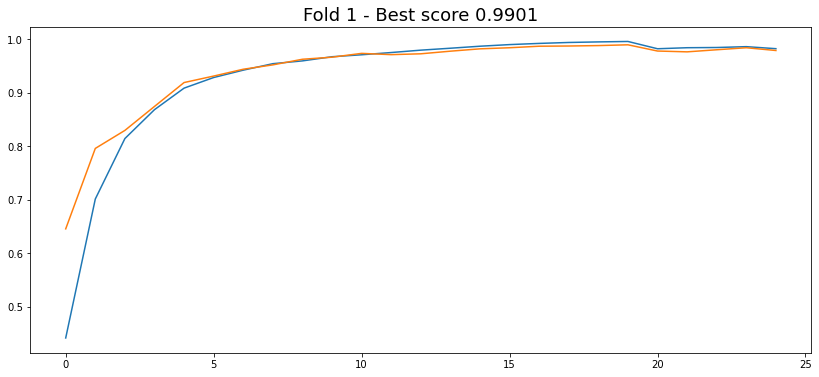

========== fold: 0 result ==========
Score (without expiratory phase): 0.9901
========== fold: 1 training ==========


init LSTM(58, 1024, batch_first=True, bidirectional=True)
init LSTM(2048, 512, batch_first=True, bidirectional=True)
init LSTM(1024, 256, batch_first=True, bidirectional=True)
init LSTM(1536, 128, batch_first=True, bidirectional=True)


Epoch 1 - avg_train_loss: 0.4472  avg_val_loss: 0.6457  time: 10s, lr: 0.00099, ACC: 0.6457, Best Score
Epoch 2 - avg_train_loss: 0.7319  avg_val_loss: 0.7997  time: 10s, lr: 0.00098, ACC: 0.7997, Best Score
Epoch 3 - avg_train_loss: 0.8378  avg_val_loss: 0.8722  time: 10s, lr: 0.00095, ACC: 0.8722, Best Score
Epoch 4 - avg_train_loss: 0.8846  avg_val_loss: 0.9011  time: 10s, lr: 0.00091, ACC: 0.9011, Best Score
Epoch 5 - avg_train_loss: 0.8887  avg_val_loss: 0.8967  time: 9s, lr: 0.00086, ACC: 0.8967, 
Epoch 6 - avg_train_loss: 0.9190  avg_val_loss: 0.9227  time: 10s, lr: 0.00080, ACC: 0.9227, Best Score
Epoch 7 - avg_train_loss: 0.9328  avg_val_loss: 0.9451  time: 9s, lr: 0.00073, ACC: 0.9451, Best Score
Epoch 8 - avg_train_loss: 0.9451  avg_val_loss: 0.9491  time: 10s, lr: 0.00066, ACC: 0.9491, Best Score
Epoch 9 - avg_train_loss: 0.9540  avg_val_loss: 0.9478  time: 9s, lr: 0.00058, ACC: 0.9478, 
Epoch 10 - avg_train_loss: 0.9590  avg_val_loss: 0.9656  time: 9s, lr: 0.00051, ACC: 0.

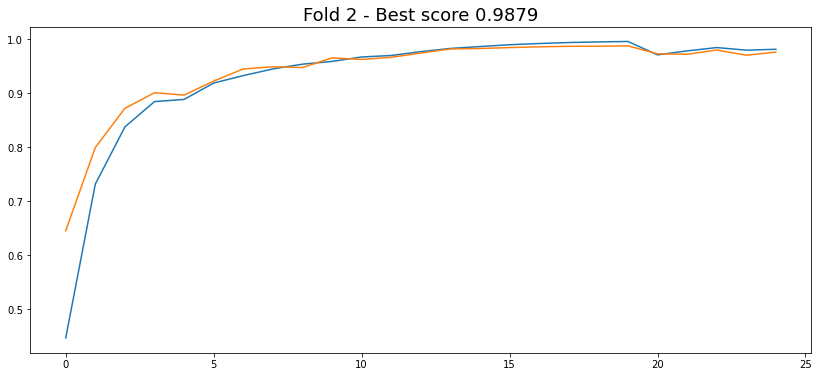

========== fold: 1 result ==========
Score (without expiratory phase): 0.9879
========== fold: 2 training ==========


init LSTM(58, 1024, batch_first=True, bidirectional=True)
init LSTM(2048, 512, batch_first=True, bidirectional=True)
init LSTM(1024, 256, batch_first=True, bidirectional=True)
init LSTM(1536, 128, batch_first=True, bidirectional=True)


Epoch 1 - avg_train_loss: 0.4967  avg_val_loss: 0.6715  time: 9s, lr: 0.00099, ACC: 0.6715, Best Score
Epoch 2 - avg_train_loss: 0.7580  avg_val_loss: 0.8306  time: 9s, lr: 0.00098, ACC: 0.8306, Best Score
Epoch 3 - avg_train_loss: 0.8486  avg_val_loss: 0.8571  time: 10s, lr: 0.00095, ACC: 0.8571, Best Score
Epoch 4 - avg_train_loss: 0.8845  avg_val_loss: 0.8866  time: 10s, lr: 0.00091, ACC: 0.8866, Best Score
Epoch 5 - avg_train_loss: 0.9027  avg_val_loss: 0.9086  time: 9s, lr: 0.00086, ACC: 0.9086, Best Score
Epoch 6 - avg_train_loss: 0.9175  avg_val_loss: 0.9324  time: 9s, lr: 0.00080, ACC: 0.9324, Best Score
Epoch 7 - avg_train_loss: 0.9147  avg_val_loss: 0.9164  time: 9s, lr: 0.00073, ACC: 0.9164, 
Epoch 8 - avg_train_loss: 0.9339  avg_val_loss: 0.9341  time: 9s, lr: 0.00066, ACC: 0.9341, Best Score
Epoch 9 - avg_train_loss: 0.9445  avg_val_loss: 0.9368  time: 9s, lr: 0.00058, ACC: 0.9368, Best Score
Epoch 10 - avg_train_loss: 0.9550  avg_val_loss: 0.9606  time: 9s, lr: 0.00051, A

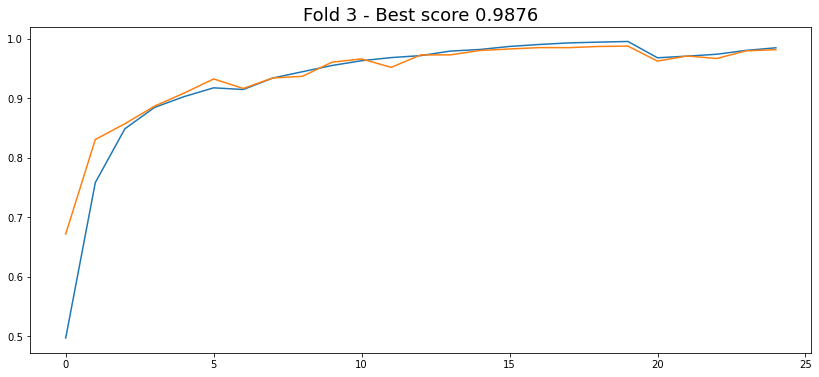

========== fold: 2 result ==========
Score (without expiratory phase): 0.9876
========== fold: 3 training ==========


init LSTM(58, 1024, batch_first=True, bidirectional=True)
init LSTM(2048, 512, batch_first=True, bidirectional=True)
init LSTM(1024, 256, batch_first=True, bidirectional=True)
init LSTM(1536, 128, batch_first=True, bidirectional=True)


Epoch 1 - avg_train_loss: 0.5173  avg_val_loss: 0.6945  time: 10s, lr: 0.00099, ACC: 0.6945, Best Score
Epoch 2 - avg_train_loss: 0.7838  avg_val_loss: 0.8443  time: 10s, lr: 0.00098, ACC: 0.8443, Best Score
Epoch 3 - avg_train_loss: 0.8616  avg_val_loss: 0.8875  time: 9s, lr: 0.00095, ACC: 0.8875, Best Score
Epoch 4 - avg_train_loss: 0.8910  avg_val_loss: 0.9037  time: 10s, lr: 0.00091, ACC: 0.9037, Best Score
Epoch 5 - avg_train_loss: 0.9124  avg_val_loss: 0.9126  time: 10s, lr: 0.00086, ACC: 0.9126, Best Score
Epoch 6 - avg_train_loss: 0.9281  avg_val_loss: 0.9351  time: 9s, lr: 0.00080, ACC: 0.9351, Best Score
Epoch 7 - avg_train_loss: 0.9377  avg_val_loss: 0.9471  time: 10s, lr: 0.00073, ACC: 0.9471, Best Score
Epoch 8 - avg_train_loss: 0.9472  avg_val_loss: 0.9553  time: 9s, lr: 0.00066, ACC: 0.9553, Best Score
Epoch 9 - avg_train_loss: 0.9539  avg_val_loss: 0.9537  time: 9s, lr: 0.00058, ACC: 0.9537, 
Epoch 10 - avg_train_loss: 0.9603  avg_val_loss: 0.9605  time: 9s, lr: 0.00051

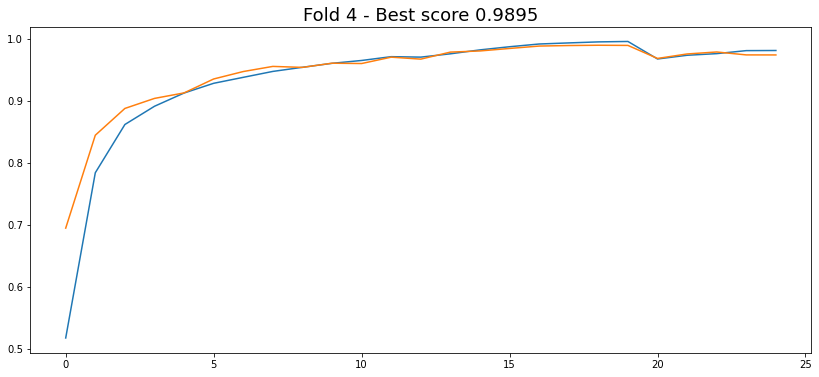

========== fold: 3 result ==========
Score (without expiratory phase): 0.9895
========== fold: 4 training ==========


init LSTM(58, 1024, batch_first=True, bidirectional=True)
init LSTM(2048, 512, batch_first=True, bidirectional=True)
init LSTM(1024, 256, batch_first=True, bidirectional=True)
init LSTM(1536, 128, batch_first=True, bidirectional=True)


Epoch 1 - avg_train_loss: 0.5080  avg_val_loss: 0.6832  time: 9s, lr: 0.00099, ACC: 0.6832, Best Score
Epoch 2 - avg_train_loss: 0.7735  avg_val_loss: 0.8363  time: 10s, lr: 0.00098, ACC: 0.8363, Best Score
Epoch 3 - avg_train_loss: 0.8696  avg_val_loss: 0.8769  time: 9s, lr: 0.00095, ACC: 0.8769, Best Score
Epoch 4 - avg_train_loss: 0.9023  avg_val_loss: 0.9054  time: 9s, lr: 0.00091, ACC: 0.9054, Best Score
Epoch 5 - avg_train_loss: 0.9238  avg_val_loss: 0.9368  time: 9s, lr: 0.00086, ACC: 0.9368, Best Score
Epoch 6 - avg_train_loss: 0.9430  avg_val_loss: 0.9479  time: 9s, lr: 0.00080, ACC: 0.9479, Best Score
Epoch 7 - avg_train_loss: 0.9498  avg_val_loss: 0.9536  time: 9s, lr: 0.00073, ACC: 0.9536, Best Score
Epoch 8 - avg_train_loss: 0.9578  avg_val_loss: 0.9581  time: 9s, lr: 0.00066, ACC: 0.9581, Best Score
Epoch 9 - avg_train_loss: 0.9629  avg_val_loss: 0.9588  time: 9s, lr: 0.00058, ACC: 0.9588, Best Score
Epoch 10 - avg_train_loss: 0.9655  avg_val_loss: 0.9571  time: 9s, lr: 0

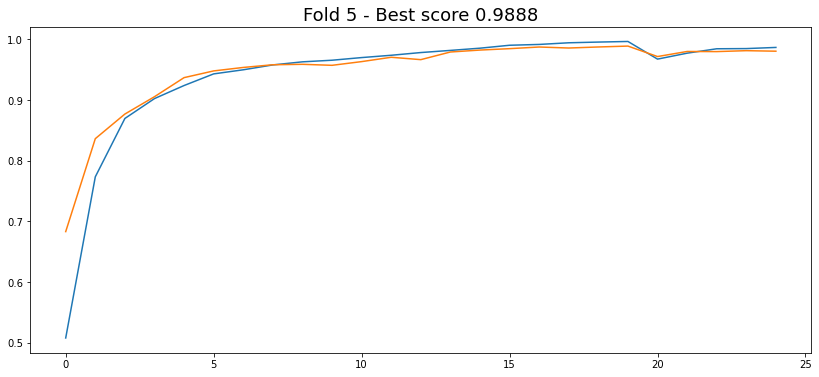

========== fold: 4 result ==========
Score (without expiratory phase): 0.9888
========== CV ==========
Score (without expiratory phase): 0.9888


init LSTM(58, 1024, batch_first=True, bidirectional=True)
init LSTM(2048, 512, batch_first=True, bidirectional=True)
init LSTM(1024, 256, batch_first=True, bidirectional=True)
init LSTM(1536, 128, batch_first=True, bidirectional=True)


  0%|          | 0/99 [00:00<?, ?it/s]

ValueError: Length of values (50300) does not match length of index (15090)

In [20]:
if __name__ == '__main__':
    main()

### R and C predictoin EDA

In [10]:
oof_df = pd.read_csv('./results/1102_C_classificatoin_lstm_hidden=1024_ver11_mod-feat11/oof_df.csv')

In [12]:
oof_df.rename(columns={'preds': 'C_pred'}, inplace=True)
oof_df = oof_df[['breath_id', 'C', 'C_pred']]
oof_df['C_pred'] = oof_df['C_pred'].astype('int64')

In [13]:
display(oof_df.head())
display(oof_df.info())

,breath_id,C,C_pred
0,5,50,50
1,15,20,20
2,42,20,20
3,47,20,20
4,49,10,10


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75450 entries, 0 to 75449
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   breath_id  75450 non-null  int64
 1   C          75450 non-null  int64
 2   C_pred     75450 non-null  int64
dtypes: int64(3)
memory usage: 1.7 MB


None

In [55]:
for i in [10, 20, 50]:
    for j in [10, 20, 50]:
        print(f'C={i} C_pred={j}: {len(oof_df[(oof_df["C"]==i) & (oof_df["C_pred"]==j)])}')

C=10 C_pred=10: 27988
C=10 C_pred=20: 52
C=10 C_pred=50: 19
C=20 C_pred=10: 45
C=20 C_pred=20: 22392
C=20 C_pred=50: 308
C=50 C_pred=10: 30
C=50 C_pred=20: 394
C=50 C_pred=50: 24222


In [14]:
print(len(oof_df[oof_df['C']!=oof_df['C_pred']]))

848


### pressure prediction EDA

In [15]:
pressure_oof_df = pd.read_csv('./results/1031_lstm_hidden=1024_ver11_mod-feat11_dropout=0.0/oof_df.csv')

In [16]:
pressure_oof_df.head()

,u_out,id,breath_id,R,C,time_step,u_in,pressure,area@AddMultiplyingDividing,u_in_cumsum@AddMultiplyingDividing,u_in_cummean@AddMultiplyingDividing,time_step_cumsum@AddMultiplyingDividing,breath_id__u_in__max@AddMultiplyingDividing,breath_id__u_in__mean@AddMultiplyingDividing,breath_id__u_in__diffmax@AddMultiplyingDividing,breath_id__u_in__diffmean@AddMultiplyingDividing,breath_time@AddBreathTimeAndUInTime,u_in_time@AddBreathTimeAndUInTime,R_dummy_20@RCDummry,R_dummy_5@RCDummry,R_dummy_50@RCDummry,C_dummy_10@RCDummry,C_dummy_20@RCDummry,C_dummy_50@RCDummry,u_in_lag1@LagFeatures,u_in_lag2@LagFeatures,u_in_lag3@LagFeatures,u_in_lag4@LagFeatures,u_in_lag-1@LagFeatures,u_in_lag-2@LagFeatures,u_in_lag-3@LagFeatures,u_in_lag-4@LagFeatures,u_out_lag1@LagFeatures,u_out_lag2@LagFeatures,u_out_lag3@LagFeatures,u_out_lag4@LagFeatures,u_out_lag-1@LagFeatures,u_out_lag-2@LagFeatures,u_out_lag-3@LagFeatures,u_out_lag-4@LagFeatures,u_in_lag1_diff@LagFeatures,u_in_lag2_diff@LagFeatures,u_in_lag3_diff@LagFeatures,u_in_lag4_diff@LagFeatures,u_out_lag1_diff@LagFeatures,u_out_lag2_diff@LagFeatures,u_out_lag3_diff@LagFeatures,u_out_lag4_diff@LagFeatures,u_in_lag-1_diff@LagFeatures,u_in_lag-2_diff@LagFeatures,u_out_lag-1_diff@LagFeatures,u_out_lag-2_diff@LagFeatures,u_in_ewm9@LagFeatures,u_in_ewm15@LagFeatures,u_in_rolling_mean4@LagFeatures,u_in_rolling_mean15@LagFeatures,u_in_rolling_max4@LagFeatures,u_in_rolling_max15@LagFeatures,u_in_rolling_min4@LagFeatures,u_in_rolling_min15@LagFeatures,u_in_rolling_std4@LagFeatures,u_in_rolling_std15@LagFeatures,u_in_rolling_sum4@LagFeatures,u_in_rolling_sum15@LagFeatures,preds
0,0,321,5,-0.333333,0.75,-0.989052,3.711844,6.329607,-0.516581,-0.669042,1.244003,-0.496658,0.250038,1.29823,-0.104509,-1.603273,-15.475736,-0.044814,0.0,1.0,0.0,0.0,0.0,1.0,-0.864121,-0.842527,-0.819258,-0.794152,4.974032,5.039258,5.291232,5.418787,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,132.850119,68.492546,44.401453,30.666883,0.0,0.0,0.0,0.0,-48.015476,-23.866392,0.0,0.0,2.688075,2.199953,0.479105,0.369347,0.643385,0.88922,0.344693,0.316541,1.618068,0.575588,0.479105,0.369347,6.263166
1,0,322,5,-0.333333,0.75,-0.963370,5.254311,7.384139,-0.512590,-0.593995,1.557929,-0.496018,0.250038,1.29823,-0.300043,-2.657233,0.249007,48.015476,0.0,1.0,0.0,0.0,0.0,1.0,3.444823,-0.842527,-0.819258,-0.794152,5.148694,5.270160,5.396331,5.660313,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,43.873530,91.143870,59.092289,40.818514,0.0,0.0,0.0,0.0,-5.713859,-5.986590,0.0,0.0,3.267327,2.682936,0.479105,0.369347,0.643385,0.88922,0.344693,0.316541,1.618068,0.575588,0.479105,0.369347,7.325165
2,0,323,5,-0.333333,0.75,-0.937036,5.439132,8.368369,-0.504267,-0.516715,1.687647,-0.494722,0.250038,1.29823,-0.323472,-2.783520,0.648565,5.713859,0.0,1.0,0.0,0.0,0.0,1.0,4.868833,3.461791,-0.819258,-0.794152,5.385263,5.375165,5.637683,5.688518,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,5.216949,25.316838,60.852572,42.034902,0.0,0.0,0.0,0.0,-7.754964,-5.004396,0.0,0.0,3.508059,2.883281,0.479105,0.369347,0.643385,0.88922,0.344693,0.316541,1.618068,0.575588,0.479105,0.369347,8.345636
3,0,324,5,-0.333333,0.75,-0.911317,5.689461,9.001088,-0.491343,-0.436410,1.777980,-0.492785,0.250038,1.29823,-0.355206,-2.954569,0.271413,7.754964,0.0,1.0,0.0,0.0,0.0,1.0,5.039460,4.884272,3.488656,-0.794152,5.492845,5.616303,5.665868,5.787857,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,7.082176,6.341633,18.783437,43.682426,0.0,0.0,0.0,0.0,-3.502223,-5.157942,0.0,0.0,3.678685,3.024349,4.263476,0.369347,3.884071,0.88922,3.552080,0.316541,4.364297,0.575588,4.263476,0.369347,9.012208
4,0,325,5,-0.333333,0.75,-0.885525,5.803301,9.774412,-0.473835,-0.354729,1.841448,-0.490206,0.250038,1.29823,-0.369637,-3.032356,0.316446,3.502223,0.0,1.0,0.0,0.0,0.0,1.0,5.270565,5.054716,4.912325,3.518006,5.739901,5.644463,5.765135,5.726151,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,3.195885,5.299265,5.176842,13.713604,0.0,0.0,0.0,0.0,-8.100707,-4.005137,0.0,0.0,3.799753,3.124122,4.710389,0.369347,3.962919,0.88922,4.980904,0.3165

In [19]:
masked_df = pressure_oof_df[['u_out', 'breath_id', 'R', 'C', 'pressure', 'preds']]
masked_df['error'] = np.abs(masked_df['pressure']-masked_df['preds'])

masked_df['error'] = masked_df.mask(masked_df['u_out']==1)['error']

In [21]:
masked_df = pd.merge(masked_df[['u_out', 'breath_id', 'pressure', 'preds', 'error']], oof_df[['breath_id', 'C', 'C_pred']], on='breath_id')

In [23]:
masked_target_df = masked_df[masked_df['C']!=masked_df['C_pred']]
masked_target_df.head()

,u_out,breath_id,pressure,preds,error,C,C_pred
10720,0,1107,6.470211,6.482778,0.012567,50,20
10721,0,1107,5.767190,6.116257,0.349067,50,20
10722,0,1107,6.329607,6.620781,0.291175,50,20
10723,0,1107,7.313837,7.623149,0.309313,50,20
10724,0,1107,8.719880,9.079062,0.359182,50,20


In [24]:
MAE_id = masked_df.groupby('breath_id').agg(np.nanmean)['error']
MAE_target_id = masked_target_df.groupby('breath_id').agg(np.nanmean)['error']

In [25]:
MAE_id.head()

breath_id
1    0.058857
2    0.067227
3    0.065054
4    0.236647
5    0.050873
Name: error, dtype: float64

In [26]:
MAE_id.describe()

count    75450.000000
mean         0.170554
std          0.287534
min          0.013023
25%          0.069512
50%          0.102849
75%          0.167612
max         21.123314
Name: error, dtype: float64

In [27]:
MAE_target_id.describe()

count    848.000000
mean       0.290472
std        0.524435
min        0.024137
25%        0.097836
50%        0.157674
75%        0.315053
max       10.277465
Name: error, dtype: float64

In [32]:
MAE_id_sorted = MAE_id.sort_values(ascending=False)
MAE_id_sorted.head()

breath_id
74766     21.123314
109693    11.329737
188       10.277465
49745      6.600838
9239       5.700262
Name: error, dtype: float64

<AxesSubplot:>

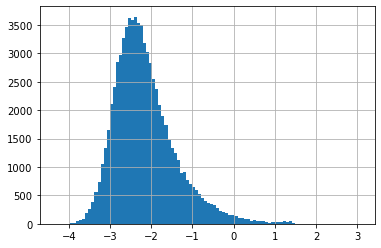

In [28]:
np.log(MAE_id).hist(bins=100)

<AxesSubplot:>

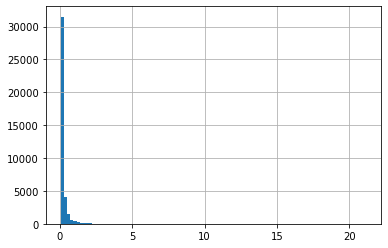

In [29]:
MAE_id.where(MAE_id > 0.1).hist(bins=100)

In [30]:
target_id = MAE_id.where(MAE_id > 1.0).dropna()
len(target_id)

1107

In [31]:
masked_target_df[(masked_target_df['C']!=masked_target_df['C_pred']) & (masked_target_df['breath_id'].isin(target_id.index.tolist()))].head()

,u_out,breath_id,pressure,preds,error,C,C_pred
26080,0,2589,5.907794,5.935073,0.027280,10,20
26081,0,2589,9.422901,9.419751,0.003150,10,20
26082,0,2589,11.391361,11.922100,0.530739,10,20
26083,0,2589,18.351274,17.901125,0.450149,10,20
26084,0,2589,21.444568,20.736975,0.707593,10,20


## make changed data

In [47]:
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sub = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [48]:
display(train[train['breath_id']==2589].head())
display(oof_df[oof_df['breath_id']==2589].head())

,id,breath_id,R,C,time_step,u_in,u_out,pressure
127840,127841,2589,20,10,0.000000,51.150954,0,5.907794
127841,127842,2589,20,10,0.031932,48.074652,0,9.422901
127842,127843,2589,20,10,0.063863,44.998443,0,11.391361
127843,127844,2589,20,10,0.096786,41.826682,0,18.351274
127844,127845,2589,20,10,0.128726,38.749622,0,21.444568


,breath_id,C,C_pred
326,2589,10,20


In [35]:
# # 全てのCを変更
# train = pd.merge(train, oof_df[['breath_id', 'C_pred']], on='breath_id')
# train['C'] = train['C_pred']
# train = train.drop(['C_pred'], axis=1)

In [49]:
# target_idのみ変更
train = pd.merge(train, oof_df[['breath_id', 'C_pred']], on='breath_id')
print(len(train[(train['breath_id'].isin(target_id.index.tolist())) & (train['C']!=train['C_pred'])])//80)
train['C'] = train['C'].mask(train['breath_id'].isin(target_id.index.tolist()), train['C_pred'])
train = train.drop(['C_pred'], axis=1)
train.head()

36


,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


In [50]:
display(train[train['breath_id']==2589].head())
display(oof_df[oof_df['breath_id']==2589].head())

,id,breath_id,R,C,time_step,u_in,u_out,pressure
127840,127841,2589,20,20,0.000000,51.150954,0,5.907794
127841,127842,2589,20,20,0.031932,48.074652,0,9.422901
127842,127843,2589,20,20,0.063863,44.998443,0,11.391361
127843,127844,2589,20,20,0.096786,41.826682,0,18.351274
127844,127845,2589,20,20,0.128726,38.749622,0,21.444568


,breath_id,C,C_pred
326,2589,10,20


In [37]:
os.makedirs('../input/ventilator-pressure-prediction/C_change/', exist_ok=True)
train.to_csv(f'../input/ventilator-pressure-prediction/C_change/train.csv', index=False)

In [51]:
os.makedirs('../input/ventilator-pressure-prediction/C_change_1.0/', exist_ok=True)
train.to_csv(f'../input/ventilator-pressure-prediction/C_change_1.0/train.csv', index=False)

## classification用のtrain data作成

In [58]:
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sub = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [59]:
target_id = MAE_id.where(MAE_id < 0.15).dropna()
len(target_id)

53149

In [60]:
# target_idのみ変更
train = pd.merge(train, oof_df[['breath_id', 'C_pred']], on='breath_id')
print(len(train[(train['breath_id'].isin(target_id.index.tolist())) & (train['C']==train['C_pred'])])//80)
train = train[(train['breath_id'].isin(target_id.index.tolist())) & (train['C']==train['C_pred'])]
train = train.drop(['C_pred'], axis=1)
train.head()

52746


,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


In [61]:
os.makedirs('../input/ventilator-pressure-prediction/no_noise/', exist_ok=True)
train.to_csv(f'../input/ventilator-pressure-prediction/no_noise/train.csv', index=False)